In [2]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def extract_patches(image_path, patch_size=256, stride=256):
    # Read the image
    image = cv2.imread(image_path)
    
    # Get image shape
    height, width, _ = image.shape
    
    patches = []
    
    # Extract patches
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            
    return patches


# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        imgpatches = extract_patches(imgAddr + maskNames[i] + '_sat.jpg', )
        maskpatches = extract_patches(maskAddr + maskNames[i] + '_mask.png')
#         img = cv2.resize(img, (shape, shape))
#         mask = cv2.resize(mask, (shape, shape))
#         frameObj['img'].append(img)
#         frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        frameObj['img'].extend(imgpatches)
        frameObj['mask'].extend(maskpatches)
        
    return frameObj

In [4]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

# def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
#     #first Conv
#     x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
#                               kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
#     if doBatchNorm:
#         x = tf.keras.layers.BatchNormalization()(x)
        
#     x =tf.keras.layers.Activation('relu')(x)
    
#     #Second Conv
#     x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
#                               kernel_initializer = 'he_normal', padding = 'same') (x)
#     if doBatchNorm:
#         x = tf.keras.layers.BatchNormalization()(x)
        
#     x = tf.keras.layers.Activation('relu')(x)
    
#     return x



# Now defining Unet 
# def custom_model(inputImage):
    # defining encoder Path
#     c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
#     p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
#     p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
#     c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
#     p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
#     p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
#     c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
#     p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
#     p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
#     c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
#     p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
#     p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
#     c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
#     # defining decoder path
#     u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
#     u6 = tf.keras.layers.concatenate([u6, c4])
#     u6 = tf.keras.layers.Dropout(droupouts)(u6)
#     c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
#     u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
#     u7 = tf.keras.layers.concatenate([u7, c3])
#     u7 = tf.keras.layers.Dropout(droupouts)(u7)
#     c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
#     u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
#     u8 = tf.keras.layers.concatenate([u8, c2])
#     u8 = tf.keras.layers.Dropout(droupouts)(u8)
#     c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
#     u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
#     u9 = tf.keras.layers.concatenate([u9, c1])
#     u9 = tf.keras.layers.Dropout(droupouts)(u9)
#     c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
#     output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
#     model = tf.keras.Model(inputs = [inputImage], outputs = [output])
#     return model


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def d_linknet(input_shape, num_classes):
    # Encoder (Pre-trained MobileNetV2)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Get encoder output layers
    encoder_outputs = [base_model.get_layer(name).output for name in ['block_3_expand_relu', 'block_6_expand_relu', 'block_13_expand_relu']]
    
    # Decoder
    x = encoder_outputs[-1]
    
    # First Up-sampling block
    x = UpSampling2D()(x)
    x = conv_block(x, 256)
    x = conv_block(x, 256)
    
    # Second Up-sampling block
    x = Concatenate()([x, encoder_outputs[1]])
    x = UpSampling2D()(x)
    x = conv_block(x, 128)
    x = conv_block(x, 128)
    
    # Third Up-sampling block
    x = Concatenate()([x, encoder_outputs[0]])
    x = UpSampling2D()(x)
    x = conv_block(x, 64)
    x = conv_block(x, 64)
    
    # Final Convolutional layer for segmentation
    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

# Define input shape and number of classes
input_shape = (256, 256, 3)  # e.g., (height, width, channels)
num_classes = 2  # Road / Not Road

# Create D-LinkNet model
model = d_linknet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
________________________

In [5]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
cmodel = d_linknet((256,256,3), 2)
cmodel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

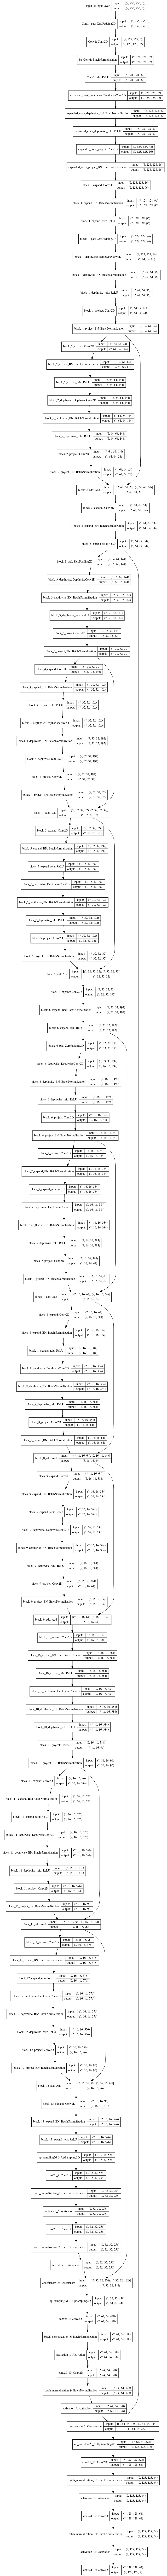

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(cmodel, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/train', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/train'
                         , shape = 256)

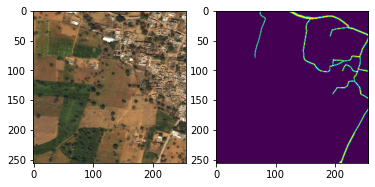

In [15]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [ ]:
def iou(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) coefficient.
    
    Args:
    y_true (Tensor): Ground truth labels.
    y_pred (Tensor): Predicted labels.
    
    Returns:
    Tensor: IoU coefficient.
    """
    # Flatten the tensors
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Calculate IoU
    iou = intersection / union
    
    return iou


In [16]:
retVal = cmodel.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 40, verbose = 1, metrics = iou)

Epoch 1/40
195/195 [==============================] - 40s 207ms/step - loss: 0.2554 - accuracy: 0.9389
Epoch 2/40
195/195 [==============================] - 40s 203ms/step - loss: 0.1539 - accuracy: 0.9534
Epoch 3/40
195/195 [==============================] - 40s 203ms/step - loss: 0.1239 - accuracy: 0.9561
Epoch 4/40
195/195 [==============================] - 40s 203ms/step - loss: 0.1044 - accuracy: 0.9600
Epoch 5/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0935 - accuracy: 0.9626
Epoch 6/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0870 - accuracy: 0.9644
Epoch 7/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0823 - accuracy: 0.9657
Epoch 8/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0790 - accuracy: 0.9665
Epoch 9/40
195/195 [==============================] - 40s 203ms/step - loss: 0.0762 - accuracy: 0.9674
Epoch 10/40
195/195 [==============================] - 40s 203ms/step - l

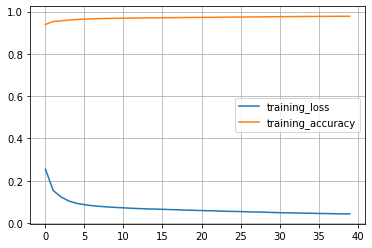

In [17]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [18]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')
    
  

In [19]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, cmodel)

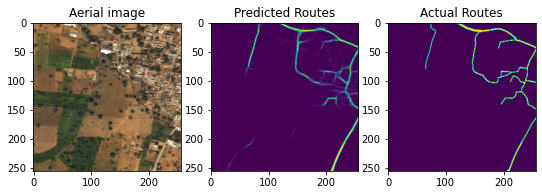

In [20]:
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

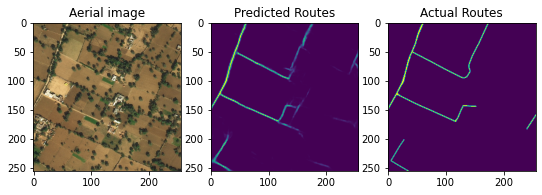

In [21]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

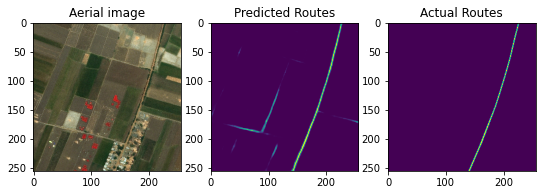

In [22]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

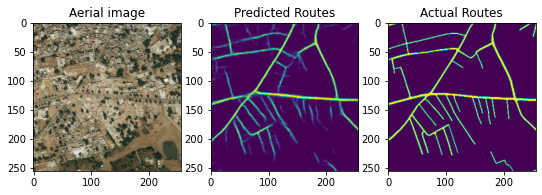

In [23]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

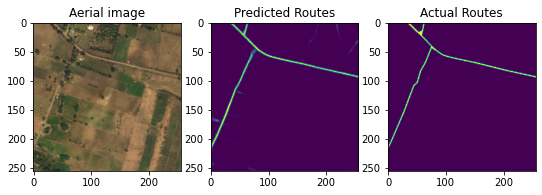

In [24]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

In [ ]:
unet.save('RouteGenerator.h5')

In [29]:
unet.save_weights("RouteGeneratorWeights.h5")

In [30]:
framObjTest = {'img' : [],
           'mask' : []
          }
framObjTest = LoadData( framObjTest, imgPath = '/kaggle/input/deepglobe-road-extraction-dataset/test', 
                        maskPath = '/kaggle/input/deepglobe-road-extraction-dataset/test'
                         , shape = 256)

In [32]:
unet.evaluate(np.array(framObjTest['img']), np.array(framObjTest['mask']), verbose = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:581: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer